# Convolutional Neural Networks

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import datasets

## Types of Layer in a ConvNet
- Convolutional layer
- Pooling layer(Maximum/Average)
- Fully connected layer

In [3]:
# some code here


## Example - Digits Sign Language 

In [4]:
# load sklearn digits dataset, which is a easier one
#digits = datasets.load_digits(return_X_y=False)

#X_all = digits.images/16.0
#X_all = X_all[:,:,:,np.newaxis]

#with tf.Session() as sess:
#    Y_all = sess.run(tf.one_hot(digits.target, 10, axis=-1))

In [5]:
# load Sign-language-digits-dataset, which is more complicated 
X_all = np.load('Sign-language-digits-dataset/X.npy')
X_all = X_all[:,:,:,np.newaxis]
Y_all = np.load('Sign-language-digits-dataset/Y.npy')

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


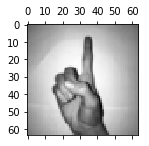

In [6]:
# plot one image
index = 900
print(Y_all[index,:])

plt.figure(figsize=(2,2))
plt.gray()
plt.matshow(X_all[index,:,:,0],fignum=1) 
plt.show() 

In [7]:
# split in train and test dataset
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.1, random_state=0)

In [8]:
learning_rate = 0.01
num_iteration = 100
print_cost = True

# train using the convolutional neural network built upon tensorflow
tf.reset_default_graph()
tf.set_random_seed(0)

X = tf.placeholder(tf.float32,shape=[None,64,64,1],name='X')
Y = tf.placeholder(tf.float32,shape=[None,10],name='Y')


W1 = tf.get_variable('W1',[3,3,1,8],initializer=tf.contrib.layers.xavier_initializer(seed=1))
# conv1
Z1 = tf.nn.conv2d(X,W1,strides=1,padding = 'SAME')
A1 = tf.nn.relu(Z1)

# max pooling1
P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

# conv2
W2 = tf.get_variable('W2',[3,3,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=1))
Z2 = tf.nn.conv2d(P1,W2,strides=1,padding = 'SAME')
A2 = tf.nn.relu(Z2)

# max pooling2
P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

# flatten
P2_flat = tf.contrib.layers.flatten(P2)

# fully connected
Z3 = tf.contrib.layers.fully_connected(P2_flat, 10, activation_fn=None) 
# this just run the linear operation by setting activation_fn=None

# softmax
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(num_iteration):
        
        # implement mini-batch later
        
        _,cost_value = sess.run([optimizer,cost],feed_dict={X:X_train,Y:Y_train})
        
        if print_cost == True and i % 10 == 0:
                print ("Cost after epoch {}: {}".format(i,cost_value))
    
    W1_value = sess.run(W1)
    W2_value = sess.run(W2)
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    print("Train Accuracy:", train_accuracy)
    
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print("Test Accuracy:", test_accuracy)

W1003 22:16:27.289873 140736475816896 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1003 22:16:27.329560 140736475816896 deprecation.py:323] From /Applications/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W1003 22:16:27.857584 140736475816896 deprecation.py:323] From <ipython-input-8-e9c8c4c25689>:37: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updati

Cost after epoch 0: 2.337419271469116
Cost after epoch 10: 2.259026288986206
Cost after epoch 20: 2.0474190711975098
Cost after epoch 30: 1.452917456626892
Cost after epoch 40: 0.9716278314590454
Cost after epoch 50: 0.6802651286125183
Cost after epoch 60: 0.5095874071121216
Cost after epoch 70: 0.400489866733551
Cost after epoch 80: 0.333442360162735
Cost after epoch 90: 0.279442697763443
Train Accuracy: 0.9266846
Test Accuracy: 0.8695652


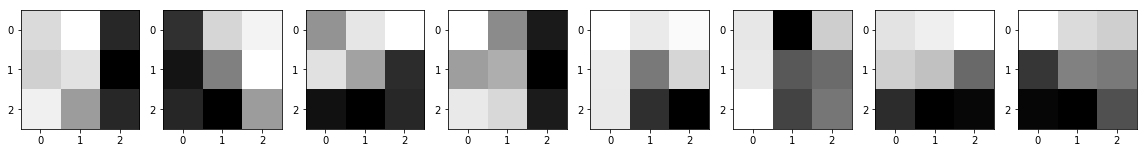

In [11]:
# plot the the weights of the first layer to show edge detection effect
# write some explanation and refer the imaginary flow of CNN, according to this paper https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
plt.figure(figsize=[20,3])
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.gray()
    plt.imshow(W1_value[:,:,0,i])
plt.show() 